## Импорт датасета и предобработка.

In [23]:
import json
import numpy as np
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from matplotlib import pyplot as plt

In [24]:
with open("reviews_data.json", "r") as read_file:
    load_data = json.load(read_file)

In [25]:
reviews = []
reviews += load_data['good']
reviews += load_data['bad']
reviews += load_data['neutral']
len(reviews)

3000

In [26]:
labels = [1 for _ in range(1000)] + [-1 for _ in range(1000)] + [0 for _ in range(1000)]
len(labels)

3000

In [27]:
max_len = 500
training_samples = 2400
max_words = 10000

In [28]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)

In [29]:
sequences = tokenizer.texts_to_sequences(reviews)
len(sequences)

3000

In [30]:
word_index = tokenizer.word_index

In [31]:
data = pad_sequences(sequences, maxlen=max_len)
len(data)

3000

In [32]:
labels = np.asarray(labels)

In [33]:
def to_one_hot(labels, dimension=3):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

labels = to_one_hot(labels)
labels.shape

(3000, 3)

In [34]:
indices = np.arange(3000)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [35]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_test = data[training_samples:]
y_test = labels[training_samples:]

## Обучение с предварительно обученными векторными предствалениями слов.

In [36]:
import gensim
import gensim.downloader as download_api
russian_model = download_api.load('word2vec-ruscorpora-300')

In [37]:
len(russian_model.index_to_key)

184973

In [38]:
list(russian_model.index_to_key)[0]

'весь_DET'

In [39]:
import re

russian_dict = []
for x in list(russian_model.index_to_key):
    russian_dict.append(re.sub(r'_\w*', '', x))
len(russian_dict)

184973

In [40]:
embedding_matrix = np.zeros((max_words, 300))
for word, i in word_index.items():
    if i < max_words:
        try:
            word_index = russian_dict.index(word)
            word_in_model = list(russian_model.index_to_key)[word_index]
            embedding_vector = russian_model.get_vector(word_in_model)
        except ValueError:
            embedding_vector = None 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [41]:
vector_model = Sequential()
vector_model.add(Embedding(max_words, 300, input_length=max_len))
vector_model.add(Flatten())
vector_model.add(Dense(32, activation='relu'))
vector_model.add(Dense(3, activation='softmax'))
vector_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          3000000   
                                                                 
 flatten_1 (Flatten)         (None, 150000)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                4800032   
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 7,800,131
Trainable params: 7,800,131
Non-trainable params: 0
_________________________________________________________________


In [42]:
vector_model.layers[0].set_weights([embedding_matrix])
vector_model.layers[0].trainable = False

In [43]:
vector_model.compile(optimizer='rmsprop',
                     loss='categorical_crossentropy',
                     metrics=['acc'])
vector_model_history = vector_model.fit(X_train, y_train,
                                        epochs=10,
                                        batch_size=32,
                                        validation_split=0.2)

Epoch 1/10
60/60 [==============================] - 3s 40ms/step - loss: 1.0897 - acc: 0.3802 - val_loss: 1.0695 - val_acc: 0.4333
Epoch 2/10
60/60 [==============================] - 2s 38ms/step - loss: 0.5283 - acc: 0.8693 - val_loss: 1.1587 - val_acc: 0.4125
Epoch 3/10
60/60 [==============================] - 2s 38ms/step - loss: 0.1414 - acc: 0.9839 - val_loss: 1.3726 - val_acc: 0.3917
Epoch 4/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0389 - acc: 0.9979 - val_loss: 1.3696 - val_acc: 0.3896
Epoch 5/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0141 - acc: 0.9995 - val_loss: 1.4801 - val_acc: 0.4083
Epoch 6/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0065 - acc: 0.9995 - val_loss: 1.5803 - val_acc: 0.3938
Epoch 7/10
60/60 [==============================] - 2s 37ms/step - loss: 0.0035 - acc: 0.9995 - val_loss: 1.6797 - val_acc: 0.3958
Epoch 8/10
60/60 [==============================] - 2s 38ms/step - loss: 0.0021 - a

In [44]:
def plotting(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
    plt.plot(epochs, val_acc, 'b', color='orange', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
    plt.plot(epochs, val_loss, 'b', color='orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

C:\Users\kozyr\AppData\Local\Temp\ipykernel_2400\2124928173.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
C:\Users\kozyr\AppData\Local\Temp\ipykernel_2400\2124928173.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', color='orange', label='Validation acc')
C:\Users\kozyr\AppData\Local\Temp\ipykernel_2400\2124928173.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
C:\Users\kozyr\AppData\Local\Temp\ipykernel_2400\2124928173.py:15: UserWarning: col

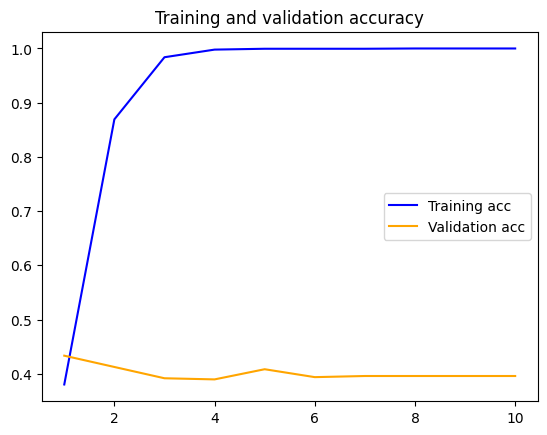

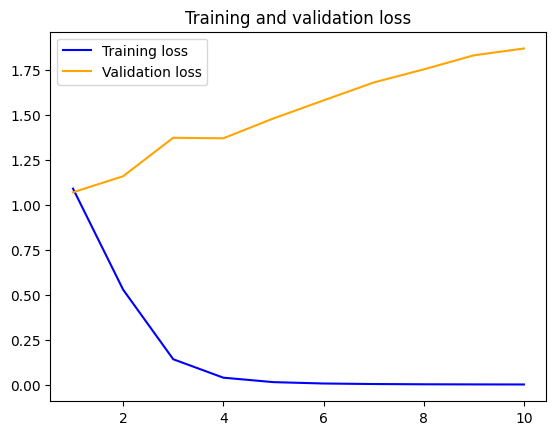

In [45]:
plotting(vector_model_history)

In [46]:
vector_model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 7ms/step - loss: 1.7508 - acc: 0.4567


[1.7508052587509155, 0.4566666781902313]